In [1]:
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib
import os, sys
from math import floor

sys.path.append("code/")
from training import create_checkpoint_filename



INFO:numexpr.utils:Note: detected 80 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 80 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


In [2]:
def load_linear(ts, y, start_day, end_day):
    y_shape=y.shape
    y_pred_linear = np.empty(y_shape)
        
    #loop over 4 timeslots in one day
    for offset in range(4):
        y_avv=np.mean(y[np.where(ts==start_day)[0][0]+offset:np.where(ts==end_day)[0][0]:4],axis=0)
        num_inserts=ts[offset:None:4].shape[0]
        y_pred_linear[offset:None:4,...]=np.repeat(y_avv[np.newaxis,:,:,:],num_inserts,axis=0)

    return y_pred_linear

In [3]:
def compute_skill(y, y_pred, ts):
    y_pred_ts=y_pred.view().reshape((y.shape[0], np.prod(y.shape[1:])))
    y_ts=y.view().reshape((y.shape[0], np.prod(y.shape[1:])))
    
    skill = 1-np.mean((y_pred_ts-y_ts)**2,axis=1)/np.mean((y_ts)**2,axis=1)
    return skill

In [4]:
#updates parameter tuple and resets the network
def increment_parameter_tuple(p_before):
  fn_before = create_checkpoint_filename(p_before)
  p_new=list(p_before)
  p_new[start_day_postion_in_the_list]=p_new[start_day_postion_in_the_list]+training_step_length
  p_new=tuple(p_new)
  fn_new = create_checkpoint_filename(p_new)
  return p_new


In [5]:
def moveav(data, window_length=3):
    tmp1=np.convolve(data, np.ones(window_length), 'same') 
    tmp2 = np.convolve(np.ones(len(data)), np.ones(window_length), 'same')
    tmp = tmp1/tmp2
    return tmp

In [26]:
#paramenter block 
varn='t'
training_step_length=7
start_day_postion_in_the_list=-3
starting_step = 168
number_of_training_steps = 65
number_of_training_steps = floor((217-starting_step)/training_step_length)
wds=[0.01]*8
for i in range(1,len(wds)):
  wds[i]=wds[i-1]/10.0
wds=[100, 37, 14, 5, 2,  1,  0.5, 0.1, 0.01, 0.001, 0.0001 ]

#create parameter tuples
wds_postion_in_the_list = -5
p=list(('tpsuvq', 'online', 't', 4, '1', '4096', 3, 0.25, 8, 'mse', 0.0001, wds[0], 'sub', starting_step, 14, 0.7))
param_list=[]
for w in wds:
  p[wds_postion_in_the_list]=w
  param_list.append(tuple(p))



In [11]:
#load truth
y = np.load('npys/y_conv2d_tpsuvq_online_'+varn+'.npy')
ts = np.arange(y.shape[0])/4

In [12]:
#compute linear baseline
y_pred_linear = load_linear(ts, y, 10, 375)
skill_linear = compute_skill(y, y_pred_linear, ts)

In [13]:
#load nn trained with 365 days
y_pred_nn = np.load('npys_365/ypred_conv2d_tpsuvq_online_'+varn+'_4_1_4096_3_0.25_8_mse_0.0001_0.05_sub_375_365_0.7.npy')
skill_nn365 = compute_skill(y, y_pred_nn, ts)

In [28]:
#load skills
skills = np.empty((len(y), number_of_training_steps, len(wds)))
ptmp=list(('tpsuvq', 'online', varn, 4, '1', '4096', 3, 0.25, 8, 'mse', 0.0001, wds[0], 'sub', starting_step, 14, 0.7))
for step in range(number_of_training_steps):
    param_list_new=[]
    for w in range(len(wds)):
        ptmp=param_list[w]
        fntmp1 = create_checkpoint_filename(ptmp)
        fntmp2 = os.path.join('npys','expvar_'+os.path.split(fntmp1)[-1]+'.npy')
        skills[:, step, w]=np.load(fntmp2)

        #increment parameter tuple
        param_list_new.append( increment_parameter_tuple(ptmp) )
    param_list=param_list_new
    


(14.0, 250.0)

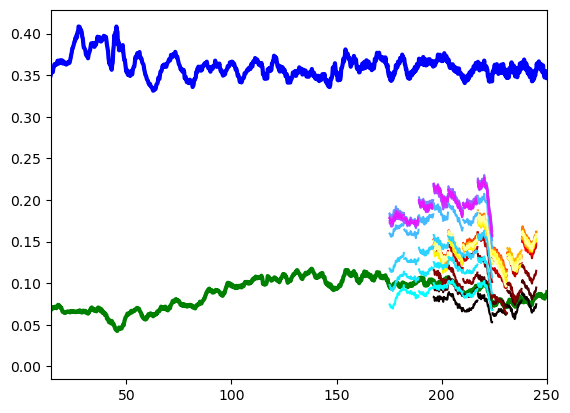

In [29]:
fig, ax = plt.subplots()
cmap7 = matplotlib.cm.get_cmap('cool')
cmap14 = matplotlib.cm.get_cmap('hot')
smooth=9

idx_test=np.where( (ts>=0) )
ax.plot(ts[idx_test], moveav(skill_linear[idx_test],smooth), color='g',linewidth=3, label='linear 365')
ax.plot(ts[idx_test], moveav(skill_nn365[idx_test],smooth), color='b',linewidth=3, label='nn 365')

for step in range(number_of_training_steps):
    start=starting_step+(training_step_length*step)+0.25
    idx_test=np.where( (ts>=start+training_step_length) & (ts<(start+training_step_length+7)) )
    if len(idx_test[0])>1:
        for w in range(len(wds)):
            tmp = np.ndarray.flatten(skills[idx_test[0],step,w])
            ax.plot(ts[idx_test], moveav(tmp,smooth), color=cmap7(w/len(wds)))
    idx_test=np.where( (ts>=start+training_step_length+21) & (ts<(start+training_step_length+28)) )
    if len(idx_test[0])>1:
        for w in range(len(wds)):
            tmp = np.ndarray.flatten(skills[idx_test[0],step,w])
            ax.plot(ts[idx_test], moveav(tmp,smooth), color=cmap14(w/len(wds)))
pass


#ax.set_ylim(0,0.4)
ax.set_xlim(14,250)
#ax.legend(['linear 365','nn 365','nn 7 (week 1)','nn 7 (week 4)'])
#ax.set_xlabel('Test days')
#ax.set_ylabel('skill [perc explained]')
#ax.set_title(f"skill for {varn}")


In [62]:
step=0
w=0
start=starting_step+(training_step_length*step)+0.25
idx_test=np.where( (ts>=start+training_step_length) & (ts<(start+training_step_length+7)) )
display(moveav(np.ndarray.flatten(skills[idx_test,step,w]),5))
display(ts[idx_test])

array([0.11832857, 0.12246493, 0.11898193, 0.11941544, 0.11510149,
       0.12323327, 0.12055016, 0.12874744, 0.12440779, 0.1298709 ,
       0.12950717, 0.1327466 , 0.13025353, 0.14074483, 0.14665505,
       0.14591237, 0.14842778, 0.15076749, 0.14529265, 0.14173374,
       0.14293174, 0.13942115, 0.14252646, 0.14488671, 0.15181376,
       0.15139674, 0.156076  , 0.15450263])

array([21.25, 21.5 , 21.75, 22.  , 22.25, 22.5 , 22.75, 23.  , 23.25,
       23.5 , 23.75, 24.  , 24.25, 24.5 , 24.75, 25.  , 25.25, 25.5 ,
       25.75, 26.  , 26.25, 26.5 , 26.75, 27.  , 27.25, 27.5 , 27.75,
       28.  ])